In [1]:
import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [2]:
# importing some libraries
import pyspark
from pyspark.sql import SQLContext, SparkSession
import os
sc = SparkSession.builder.appName('App Name').master("local[*]").getOrCreate()
sqlContext = SQLContext(sparkContext=sc.sparkContext, sparkSession=sc)

from nltk.corpus import stopwords
import re as re
from pyspark.ml.feature import CountVectorizer , IDF# stuff we'll need for building the model

from pyspark.mllib.linalg import Vector, Vectors
from pyspark.mllib.clustering import LDA, LDAModel# reading the data
data = sqlContext.read.format("csv") \
   .options(header='true', inferschema='true') \
   .load(os.path.realpath("data/classics_clean.csv"))

22/04/10 20:40:50 WARN Utils: Your hostname, DSGPU05 resolves to a loopback address: 127.0.1.1; using 10.10.11.64 instead (on interface eno1)
22/04/10 20:40:50 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/10 20:40:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/04/10 20:40:51 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
classics = data.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)
StopWords = stopwords.words("english")
tokens = classics                                                  \
    .map( lambda document: document.strip().lower())               \
    .map( lambda document: re.split(" ", document))          \
    .map( lambda word: [x for x in word if x.isalpha()])           \
    .map( lambda word: [x for x in word if len(x) > 3] )           \
    .map( lambda word: [x for x in word if x not in StopWords])    \
    .zipWithIndex()

In [6]:
df_txts = sqlContext.createDataFrame(tokens, ["list_of_words",'index'])# TF
cv = CountVectorizer(inputCol="list_of_words", outputCol="raw_features", vocabSize=10000, minDF=1.0)
cvmodel = cv.fit(df_txts)
result_cv = cvmodel.transform(df_txts)# IDF
idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv) 

In [10]:
from pyspark.sql.functions import udf, col, StringType, column
from pyspark.ml.feature import RegexTokenizer, CountVectorizer
from pyspark.ml.linalg import Vectors, SparseVector
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import CountVectorizer
df_txts = sqlContext.createDataFrame(tokens, ["list_of_words",'index'])# TF
cv = CountVectorizer(inputCol="list_of_words", outputCol="raw_features", vocabSize=5000, minDF=1.0)
cvmodel = cv.fit(df_txts)
result_cv = cvmodel.transform(df_txts)
# IDF
idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv) 

In [11]:
result_cv

DataFrame[list_of_words: array<string>, index: bigint, raw_features: vector]

In [12]:
num_topics = 10
max_iterations = 100
lda = LDA(k=num_topics, maxIter=max_iterations)
lda_model = lda.fit(result_tfidf[['index','features']])

22/04/10 20:42:53 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/04/10 20:42:53 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [13]:
lda_model.vocabSize()

5000

In [14]:
lda_model.describeTopics().show()

+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[234, 248, 635, 7...|[0.05027498542396...|
|    1|[61, 22, 212, 560...|[0.08213519918886...|
|    2|[150, 189, 481, 6...|[0.07397217631471...|
|    3|[45, 51, 94, 107,...|[0.01901450482208...|
|    4|[61, 1027, 397, 2...|[0.01910487862563...|
|    5|[103, 156, 764, 5...|[0.09112221045460...|
|    6|[45, 51, 94, 107,...|[0.05843688634204...|
|    7|[234, 248, 754, 6...|[0.00935516297401...|
|    8|[180, 243, 251, 9...|[0.05335335360379...|
|    9|[211, 620, 629, 7...|[0.03973114657032...|
+-----+--------------------+--------------------+



/opt/spark/python/lib/pyspark.zip/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.


In [15]:
lda_model.topicsMatrix()

DenseMatrix(5000, 10, [0.408, 0.4445, 0.449, 0.4081, 0.4988, 0.4531, 0.4519, 0.4155, ..., 0.7266, 0.3765, 1.3343, 1.2336, 0.9226, 0.4546, 1.3208, 0.4482], 0)

In [16]:
vocabulary = cvmodel.vocabulary

In [17]:
topics_model = lda_model.describeTopics()

In [18]:
from pyspark.sql.types import *
vocab = cvmodel.vocabulary
vocab_broadcast = sc.sparkContext.broadcast(vocab)

#creating LDA model
ldatopics = lda_model.describeTopics()

def map_termID_to_Word(termIndices):
    words = []
    for termID in termIndices:
        words.append(vocab_broadcast.value[termID])

    return words

udf_map_termID_to_Word = udf(map_termID_to_Word , ArrayType(StringType()))

ldatopics_mapped = ldatopics.withColumn("topic_desc", udf_map_termID_to_Word(ldatopics.termIndices))

In [19]:
ldatopics_mapped.show()

+-----+--------------------+--------------------+--------------------+
|topic|         termIndices|         termWeights|          topic_desc|
+-----+--------------------+--------------------+--------------------+
|    0|[234, 248, 635, 7...|[0.05027498542396...|[colin, dickon, m...|
|    1|[61, 22, 212, 560...|[0.08213519918886...|[marilla, anne, m...|
|    2|[150, 189, 481, 6...|[0.07397217631471...|[heathcliff, lint...|
|    3|[45, 51, 94, 107,...|[0.01901450482208...|[lydgate, dorothe...|
|    4|[61, 1027, 397, 2...|[0.01910487862563...|[marilla, teachum...|
|    5|[103, 156, 764, 5...|[0.09112221045460...|[laurie, beth, la...|
|    6|[45, 51, 94, 107,...|[0.05843688634204...|[lydgate, dorothe...|
|    7|[234, 248, 754, 6...|[0.00935516297401...|[colin, dickon, w...|
|    8|[180, 243, 251, 9...|[0.05335335360379...|[darcy, bennet, b...|
|    9|[211, 620, 629, 7...|[0.03973114657032...|[rochester, fairf...|
+-----+--------------------+--------------------+--------------------+



In [20]:
from pyspark.sql.functions import concat_ws, split
import pyspark.sql.functions as f
lda_topics_mapped = ldatopics_mapped.withColumn("topic_desc", concat_ws(" ", ldatopics_mapped.topic_desc).alias("topic_desc_str"))

lda_topics_mapped.show()

+-----+--------------------+--------------------+--------------------+
|topic|         termIndices|         termWeights|          topic_desc|
+-----+--------------------+--------------------+--------------------+
|    0|[234, 248, 635, 7...|[0.05027498542396...|colin dickon medl...|
|    1|[61, 22, 212, 560...|[0.08213519918886...|marilla anne matt...|
|    2|[150, 189, 481, 6...|[0.07397217631471...|heathcliff linton...|
|    3|[45, 51, 94, 107,...|[0.01901450482208...|lydgate dorothea ...|
|    4|[61, 1027, 397, 2...|[0.01910487862563...|marilla teachum j...|
|    5|[103, 156, 764, 5...|[0.09112221045460...|laurie beth laure...|
|    6|[45, 51, 94, 107,...|[0.05843688634204...|lydgate dorothea ...|
|    7|[234, 248, 754, 6...|[0.00935516297401...|colin dickon weat...|
|    8|[180, 243, 251, 9...|[0.05335335360379...|darcy bennet bing...|
|    9|[211, 620, 629, 7...|[0.03973114657032...|rochester fairfax...|
+-----+--------------------+--------------------+--------------------+



In [21]:
counts = lda_topics_mapped.withColumn('word', f.explode(f.split(f.col('topic_desc'), ' ')))\
    .groupBy('word')\
    .count()\
    .sort('count', ascending=True)

In [22]:
counts.show()

+-----------+-----+
|       word|count|
+-----------+-----+
|     joseph|    1|
|       demi|    1|
| heathcliff|    1|
|      cathy|    1|
|      teddy|    1|
|    hareton|    1|
|     rachel|    1|
|   earnshaw|    1|
|      josie|    1|
|middlemarch|    1|
|    gilbert|    1|
|farebrother|    1|
|      lynde|    1|
|       hebe|    1|
|   isabella|    1|
|    rozella|    1|
|    hindley|    1|
|   benefico|    1|
|  catherine|    1|
|      sukey|    1|
+-----------+-----+
only showing top 20 rows



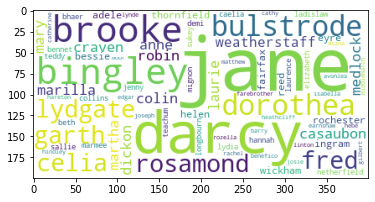

In [23]:
import pyspark.sql.functions as F
from collections import ChainMap
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(background_color="white")

words = dict(ChainMap(*counts.select(F.create_map('word', 'count')).rdd.map(lambda x: x[0]).collect()))
# {'scorbutically': 1.76, 'punta': 1.76, 'detail': 1.789, 'lafayette': 1.8, 'maya': 1.854, 'prostate': 1.854, 'quot': 1.856, 'mark': 1.949, 'elite': 1.988, 'trade': 2.012, 'write': 2.083}

plt.imshow(wordcloud.generate_from_frequencies(words))

plt.show()
